In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#RMSLE
import timeit
import math
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
#LET's make our scorer 
from sklearn import metrics
rmsle_score = metrics.make_scorer(rmsle, greater_is_better=False)

In [4]:
# Make predictions fit for Kaggle
# No negatives
def fit_for_kaggle(y):
    for i in range(len(y)):
        y[i] = max(0,y[i])
# Only int
    y = y.astype(int)
    return y

In [5]:
# Exports in Kaggle format
def Export_for_Kaggle(y_pred, path):
# path is the name of the file "x.csv"
    data_out = pd.DataFrame(y_pred, columns = ['Prediction'])
    data_out.index.name = 'Id'
    data_out.to_csv(path, sep = ",")
    
    return

In [77]:
#import all data
feature_data = pd.read_csv('kaggle_data/features.txt', header=None, sep="  ", names=['feature_names', 'feature_description'], engine='python')
list_feature_names = list(feature_data['feature_names'])
train_data = pd.read_csv('kaggle_data/train.csv', header=None, sep=" ", names=list_feature_names)
test_data=pd.read_csv('kaggle_data/test-val.csv',header=None,sep=" ",names=list_feature_names)
target_data = pd.read_csv('kaggle_data/train-targets.csv', sep=",")
train_data = train_data.drop(['pp_stop_words','ave_polar_neg','min_polar_neg','max_polar_neg','polar_title','subj_title','polar','nb_mina_mink'],axis=1)
pd.set_option('display.max_columns', None)
train_data.head(10)

,nb_words_title,nb_words_content,pp_uniq_words,pp_uniq_non-stop_words,nb_links,nb_outside_links,nb_images,nb_videos,ave_word_length,nb_keywords,category,nb_mina_maxk,nb_mina_avek,nb_maxa_mink,nb_maxa_maxk,nb_maxa_avek,nb_avea_mink,nb_avea_maxk,nb_avea_avek,nb_min_linked,nb_max_linked,nb_ave_linked,weekday,dist_topic_0,dist_topic_1,dist_topic_2,dist_topic_3,dist_topic_4,subj,pp_pos_words,pp_neg_words,pp_pos_words_in_nonneutral,ave_polar_pos,min_polar_pos,max_polar_pos
2000,9,843,0.5358,0.7469,15.0,8,11,1,4,9,1,369,150,0,843300,154500.0,0,4090,2422.0,850,20600,7750.0,1,0.20820,0.49280,0.02245,0.02246,0.25400,0.5108,0.04808,0.019230,0.7143,0.4437,0.03333,1.0
2001,9,805,0.4196,0.5693,8.0,7,1,0,4,4,5,551,137,3200,843300,401400.0,1486,3483,2420.0,5600,5600,5600.0,2,0.05000,0.05000,0.55070,0.05000,0.29930,0.4958,0.02956,0.025710,0.5349,0.3081,0.05000,0.8
2002,8,145,0.7594,0.8488,7.0,3,0,2,4,9,4,923,291,2500,843300,172300.0,1145,4237,2854.0,3600,10100,6850.0,0,0.02223,0.02222,0.02223,0.02248,0.91080,0.5364,0.03759,0.007519,0.8333,0.3673,0.13640,0.5
2003,12,201,0.6359,0.8148,7.0,2,0,0,4,10,4,651,230,0,690400,98370.0,0,3238,2225.0,2400,2400,2400.0,2,0.11980,0.11970,0.02003,0.02000,0.72050,0.5091,0.07568,0.027030,0.7368,0.3721,0.13640,0.6
2004,13,673,0.4609,0.5950,8.0,7,1,0,4,6,5,819,185,0,843300,196100.0,0,4134,2363.0,20000,20000,20000.0,2,0.03333,0.03333,0.69330,0.03333,0.20670,0.4057,0.02757,0.021440,0.5625,0.3500,0.05000,0.6
2005,7,293,0.6169,0.7225,24.0,22,1,0,5,9,0,272,138,23900,843300,252600.0,2890,5702,3969.0,10000,10000,10000.0,3,0.25900,0.02238,0.02267,0.02243,0.67350,0.5464,0.02612,0.011190,0.7000,0.2964,0.10000,0.7
2006,11,254,0.6009,0.7481,5.0,3,0,0,4,6,5,1100,315,0,843300,177100.0,0,3607,1881.0,756,1200,978.0,0,0.03333,0.03333,0.86670,0.03333,0.03334,0.5099,0.03896,0.030300,0.5625,0.4011,0.16000,0.5
2007,10,1034,0.4158,0.5705,4.0,0,15,1,4,7,1,396,112,15000,843300,172400.0,1469,3286,2281.0,932,1300,1116.0,4,0.19990,0.71360,0.02857,0.02894,0.02890,0.4648,0.04711,0.010790,0.8136,0.3129,0.10000,0.7
2008,8,499,0.5459,0.6208,51.0,48,0,1,5,8,5,801,356,10700,843300,337600.0,3470,49132,10310.0,2900,5000,3950.0,2,0.02500,0.35530,0.02500,0.39030,0.20440,0.4787,0.02484,0.006211,0.8000,0.5194,0.03333,0.9
2009,9,562,0.5522,0.7048,23.0,20,10,1,4,5,2,1000,335,8700,843300,451700.0,3253,13350,5861.0,988,20300,8696.0,2,0.83990,0.04000,0.04000,0.04000,0.04010,0.3972,0.04037,0.027520,0.5946,0.4188,0.10000,1.0


In [78]:
#Data engineering 
test_data = test_data.drop(['pp_stop_words','ave_polar_neg','min_polar_neg','max_polar_neg','polar_title','subj_title','polar','nb_mina_mink'],axis=1)
# 'weekday' encoding
weekday_data = pd.get_dummies(train_data['weekday'],prefix='weekday',drop_first=True)
# 'category' encoding
category_data = pd.get_dummies(train_data['category'],prefix='category',drop_first=True)
#fusion that shit
other_data = train_data.drop(['weekday','category'],axis=1)
training_data = pd.concat([category_data,weekday_data,other_data],axis=1)

In [79]:
#lets do the same with the test data
weekday_data_test=pd.get_dummies(test_data['weekday'],prefix='weekday',drop_first=True)
category_data_test=pd.get_dummies(test_data['category'],prefix='category',drop_first=True)
other_data_test=test_data.drop(['weekday','category'],axis=1)
testing_data=pd.concat([category_data_test,weekday_data_test,other_data_test],axis=1)
#see it
#testing_data.head(5)

In [86]:
#Data standardization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(training_data)
X_reg = scaler.transform(training_data)
y_reg = target_data['Prediction'].values

#scale that test data
X_test = scaler.transform(testing_data)

#visualize X_reg
print X_reg

[[ 2.12860834 -0.43740958 -0.25487787 ...,  0.85841924 -0.84504969
   0.98277162]
 [-0.46979051 -0.43740958 -0.25487787 ..., -0.43987772 -0.61279765
   0.17296496]
 [-0.46979051 -0.43740958 -0.25487787 ...,  0.1269304   0.59095615
  -1.04174503]
 ..., 
 [-0.46979051 -0.43740958 -0.25487787 ..., -0.16604812  0.08381913
   0.98277162]
 [-0.46979051 -0.43740958 -0.25487787 ..., -3.38976925 -1.30941444
  -3.06626168]
 [-0.46979051 -0.43740958 -0.25487787 ...,  1.02118508  0.08381913
   0.98277162]]


In [53]:
# Making the kfold
from sklearn import model_selection
kf = model_selection.KFold(n_splits = 10)
k_folds = kf.split(X_reg, y_reg)

In [54]:
# Setting up the Linear regression
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

In [55]:
# Predictions by Cross validation
y_pred = model_selection.cross_val_predict(lin_reg, X_reg, y_reg, cv=k_folds)
# num shares can't be negative, so 0 instead
fit_for_kaggle(y_pred)

array([2867, 2237, 4349, ..., 3674, 6793, 1897])

In [56]:
# Let's see the error
from sklearn import metrics
print("Mean squared error: %.3f" % metrics.mean_squared_error(y_reg, y_pred))

Mean squared error: 60429191.508


In [57]:
#RMSLE 
rmsle(y_reg, y_pred)

1.2177093989935257

In [58]:
# Prediction on Test set
lin_reg.fit(X_reg,y_reg)
y_test_reg = lin_reg.predict(X_test)
fit_for_kaggle(y_test_reg)
print(y_test_reg)

[ 3159.6075969   4992.74842606  1855.4661532  ...,  2680.83242045
  1919.90795272  3575.68864659]


In [16]:
#Expoeting
Export_for_Kaggle(y_test_reg, "solution_reg.csv")

In [17]:
#RIDGE
kf2 = model_selection.KFold(n_splits=5)
kf2.get_n_splits(X_reg)
folds_regr = [(tr, te) for (tr, te) in kf2.split(X_reg)]
param_grid = {'alpha': np.logspace(-3, 3, 6)}
#regr_ridge_opt = model_selection.GridSearchCV(linear_model.Ridge(), param_grid, cv=folds_regr, scoring='neg_mean_squared_log_error')
regr_ridge_opt = model_selection.GridSearchCV(linear_model.Ridge(), param_grid)
regr_ridge_opt.fit(X_reg, y_reg)
ypred_ridge_opt = regr_ridge_opt.predict(X_reg)
fit_for_kaggle(ypred_ridge_opt)
rmsle(y_reg, ypred_ridge_opt)
#print('param=', regr_ridge_opt.best_params_, 'RMSE=', np.sqrt(-1*regr_ridge_opt.best_score_))

1.055437278734848

In [18]:
#Ridge for test
y_test_ridge = regr_ridge_opt.predict(X_test)
y_test_ridge = fit_for_kaggle(y_test_ridge)
Export_for_Kaggle(y_test_ridge, "solution_ridge.csv")

In [19]:
# Lasso
regr_lasso = model_selection.GridSearchCV(linear_model.Lasso(), param_grid, cv=folds_regr)
regr_lasso.fit(X_reg, y_reg)
ypred_lasso = regr_lasso.predict(X_test)
ypred_lasso = fit_for_kaggle(ypred_lasso)
Export_for_Kaggle(ypred_lasso, "solution_lasso.csv")

C:\Users\Tariq\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [22]:
#tSNE
from sklearn import manifold
#let's make a copy of X_reg
X_reg_1 = X_reg
#let's declare it
t_SNE = manifold.TSNE(n_components = 3)
X_reg_tsne = t_SNE.fit_transform(X_reg_1, y_reg)
X_test_tsne = t_SNE.fit_transform(X_test)

KeyboardInterrupt: 

In [59]:
#PCA
from sklearn import decomposition
ACP = decomposition.PCA(n_components = 40)
ACP.fit(X_reg)
X_test_acp = ACP.transform(X_test)
X_reg_acp = ACP.transform(X_reg)


In [60]:
#knn
from sklearn import neighbors

In [81]:
#KNN again
# creating odd list of K for KNN
list_neighbors = list(range(1,50))

# subsetting just the odd ones


# empty list that will hold cv scores
cv_scores = []


# perform 10-fold cross validation
for k in list_neighbors:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    scores = model_selection.cross_val_score(knn, X_reg, y_reg, cv=10, scoring=rmsle_score)
    cv_scores.append(scores.mean())

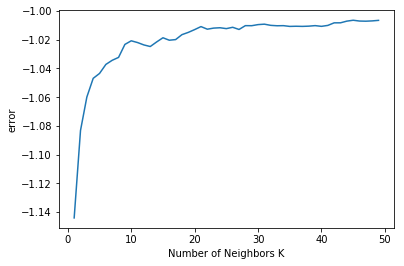

In [82]:
plt.plot(list_neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('error')
plt.show()


In [83]:
print cv_scores.index(max(cv_scores))

44


In [51]:
#let's find the best PCA
PCAList = list(range(2,52))

# empty list that will hold cv scores
cv_scores_pca = []
knn_cv = neighbors.KNeighborsRegressor(n_neighbors=14)
# perform 10-fold cross validation
for k in PCAList:
    ACP_cv = decomposition.PCA(n_components = k)
    ACP_cv.fit(X_reg)
    X_reg_cv = ACP_cv.transform(X_reg)
    scores = model_selection.cross_val_score(knn, X_reg_cv, y_reg, cv=10, scoring='neg_mean_squared_log_error')
    cv_scores_pca.append(scores.mean())

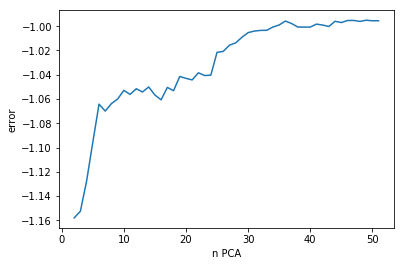

In [53]:
plt.plot(PCAList, cv_scores_pca)
plt.xlabel('n PCA')
plt.ylabel('error')
plt.show()

In [54]:
print cv_scores_pca.index(max(cv_scores_pca))

47


In [63]:
#let's fit that shiiiiiit
knn_14 = neighbors.KNeighborsRegressor(14)
PCA_47 = decomposition.PCA(47)
PCA_47.fit(X_reg)
X_reg_47 = PCA_47.transform(X_reg)
X_test_47 = PCA_47.transform(X_test)
knn_14.fit(X_reg_47, y_reg)
y_test_14_47 = knn_14.predict(X_test_47)
y_test_14_47 = fit_for_kaggle(y_test_14_47)
Export_for_Kaggle(y_test_14_47, "solution_knn_14_47.csv")

In [88]:
# double cross validation
'''ATTENTION PREND ENORMEMENT DE TEMPS A CALCULER
    NE PAS EXECUTER'''
pcaList = list(range(2,52))
knnList = list(range(1,50))
cv_scores_db = []
cv_rmsle = np.zeros((50,49))
for i in pcaList :
    for j in knnList : 
        ACP_db = decomposition.PCA(n_components = i)
        ACP_db.fit(X_reg)
        X_reg_db = ACP_db.transform(X_reg)  
        knn = neighbors.KNeighborsRegressor(n_neighbors=j)
        #scores = model_selection.cross_val_score(knn, X_reg_db, y_reg, cv=10, scoring='neg_mean_squared_log_error')
        pred = model_selection.cross_val_predict(knn, X_reg_db, y_reg, cv=10, n_jobs=-1)
        #cv_scores_db.append(scores.mean())
        cv_rmsle[i-2,j-1] = rmsle(y_reg, pred)
    

In [89]:
#let's try it 
knn_27 = neighbors.KNeighborsRegressor(13)
PCA_48 = decomposition.PCA(49)
PCA_48.fit(X_reg)
X_reg_48 = PCA_49.transform(X_reg)
X_test_48 = PCA_49.transform(X_test)
knn_27.fit(X_reg_48, y_reg)
y_test_27_48 = knn_27.predict(X_test_48)
y_test_27_48 = fit_for_kaggle(y_test_27_48)
Export_for_Kaggle(y_test_27_48, "solution_knn_13_49.csv")

In [83]:
#Lasso with PCA
regr_lasso_pca = model_selection.GridSearchCV(linear_model.Lasso(), param_grid, cv=folds_regr)
regr_lasso_pca.fit(X_reg_48, y_reg)
ypred_lasso_48 = regr_lasso_pca.predict(X_test_48)
ypred_lasso_48 = fit_for_kaggle(ypred_lasso_48)
Export_for_Kaggle(ypred_lasso_48, "solution_lasso_48.csv")

In [12]:
#Random Forest
from sklearn import ensemble
#PCA as always
PCA = decomposition.PCA(49)
PCA.fit(X_reg)
X_reg_pca = PCA.transform(X_reg)
X_test_pca = PCA.transform(X_test)

In [17]:
#Grid Search the random Forest
param_grid = {'criterion': ['mse','mae'],
             'min_samples_leaf' : [1, 2, 5],
             'n_estimators': [5, 10, 20, 50, 80]}

randomf = model_selection.GridSearchCV(ensemble.RandomForestRegressor(), param_grid, cv=10, scoring='neg_mean_squared_log_error')
randomf.fit(X_reg_pca, y_reg)
y_test_rf = randomf.predict(X_test_pca)
y_test_rf = fit_for_kaggle(y_test_rf)
Export_for_Kaggle(y_test_rf, "solution_RandomForest")

KeyboardInterrupt: 

In [85]:
#Just random forest
randomforest = ensemble.RandomForestRegressor(n_estimators = 50, max_features='sqrt')
rf_scores = model_selection.cross_val_score(randomforest, X_reg_pca, y_reg, cv=10, scoring = rmsle_score )

In [23]:
print rf_scores

[-1.08466542 -1.10300477 -1.1024676  -1.03267521 -1.0778305  -1.08842206
 -1.16990584 -1.10620081 -1.11994094 -1.09107425]


In [87]:
#Let's try KBEST
from sklearn import feature_selection
kbest = feature_selection.SelectKBest(feature_selection.f_regression, k=40)
kbest.fit(X_reg, y_reg)
X_reg_best = kbest.transform(X_reg)
X_test_best = kbest.transform(X_test)
kNN = neighbors.KNeighborsRegressor(44)
kNN.fit(X_reg_best, y_reg)
y_kNN = kNN.predict(X_test_best)
y_kNN = fit_for_kaggle(y_kNN)
Export_for_Kaggle(y_kNN,'solution_kbest_knn.csv')

In [84]:
#Cross validate Kbest
# creating odd list of K for KNN
KBestList = list(range(1,52))
# empty list that will hold cv scores
cv_scores_kbest = []
# perform 10-fold cross validation
for l in KBestList:
    kbest = feature_selection.SelectKBest(feature_selection.chi2, k=l)
    kbest.fit(X_reg, y_reg)
    X_reg_best = kbest.transform(X_reg)
    knn = neighbors.KNeighborsRegressor(n_neighbors=14)
    scores = model_selection.cross_val_score(knn, X_reg_best, y_reg, cv=10, scoring=rmsle_score)
    cv_scores_kbest.append(scores.mean())

plt.plot(KBestList, cv_scores_kbest)
plt.xlabel('n K')
plt.ylabel('error')
plt.show()
print cv_scores_kbest.index(max(cv_scores_kbest))

ValueError: Input X must be non-negative.